In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import argparse
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# tf.compat.v1.disable_eager_execution()
# tf.executing_eagerly()

2021-12-07 11:19:04.426332: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2021-12-07 11:19:08.115594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13582825062510804775,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5883742379891122453
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17021648895010584228
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14794695863118548555
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7772802912
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 16863566960454837254
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:0a:00.0, compute capability: 6.1

2021-12-07 11:19:08.116607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-07 11:19:08.116743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 11:19:08.117666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-07 11:19:08.117707: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-07 11:19:08.117745: I tensorflow/stream_executor

In [4]:
from tensorflow.python.client import device_lib
# gpus = tf.config.experimental.list_physical_devices('GPU')
# # gpus = tf.config.list_physical_devices('GPU')
# print('='*100)
# print(gpus)
# print('='*100)
print("GPU Available: ", tf.test.is_gpu_available())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print('GPU is available')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
GPU is available


2021-12-07 11:19:12.722530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 11:19:12.723620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-07 11:19:12.723772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 11:19:12.724745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandw

# 이미지 전처리

In [3]:
# train_path
train_yes_path = '/root/data/cut_data/train/yes/*.jpg'
train_no_path = '/root/data/cut_data/train/no/*.jpg'

# test_path
test_yes_path = '/root/data/cut_data/test/yes/*.jpg'
test_no_path = '/root/data/cut_data/test/no/*.jpg'

# val_path
val_yes_path ='/root/data/cut_data/validation/yes/*.jpg'
val_no_path ='/root/data/cut_data/validation/no/*.jpg'

In [4]:
# 이미지 불러오기
# trian
train_yes = glob(train_yes_path)
train_no = glob(train_no_path)

# test
test_yes = glob(test_yes_path)
test_no = glob(test_no_path)

# validation
val_yes = glob(val_yes_path)
val_no = glob(val_no_path)

# 출력
print("train_yes=", len(train_yes))
print("train_no=", len(train_no))
print("="*10)
print("test_yes=", len(test_yes))
print("test_no=", len(test_no))
print("="*10)
print("validation_yes=", len(val_yes))
print("validation_no=", len(val_no))

train_yes= 40807
train_no= 119267
test_yes= 2033
test_no= 25465
validation_yes= 664
validation_no= 8400


## 이미지 갯수 비율 맞추기

In [5]:
# 이미지 개수 비율 맞추기
def image_ratio(yes, no):
    min_num = min(len(yes),len(no))
    return yes[0:min_num], no[0:min_num]

In [6]:
# 함수 실행
train_yes , train_no = image_ratio(train_yes, train_no)
test_yes , test_no = image_ratio(test_yes, test_no)
val_yes , val_no = image_ratio(val_yes, val_no)

# 출력
print("train_yes=", len(train_yes))
print("train_no=", len(train_no))
print("="*10)
print("test_yes=", len(test_yes))
print("test_no=", len(test_no))
print("="*10)
print("validation_yes=", len(val_yes))
print("validation_no=", len(val_no))

train_yes= 40807
train_no= 40807
test_yes= 2033
test_no= 2033
validation_yes= 664
validation_no= 664


## img_to_array

In [7]:
data_list = []
label_list = []

# image 변환 및 라벨 생성
def image_preprocessing(path, data_list, label_list, label_num):
    label = label_list
    data = data_list
    for i in tqdm(path):
        image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
        target_size= (128,128)
                                             )
        image = np.array(image)
        data.append(image)
        label.append(label_num)
        

    return  data, label

In [8]:
data, label = image_preprocessing(train_yes, data_list, label_list, 1)
data, label = image_preprocessing(test_yes, data, label, 1)
data, label = image_preprocessing(train_no, data, label, 0)
data, label = image_preprocessing(test_no, data, label, 0)

data = np.array(data, dtype=np.float32)/255
label = np.array(label)

100%|█████████████████████████████████████████████| 2033/2033 [00:17<00:00, 117.28it/s]


In [14]:
data.shape

(85680, 128, 128, 3)

In [9]:
# validation set
X_val, y_val = image_preprocessing(val_yes, data_list, label_list, 1)
X_val, y_val = image_preprocessing(val_no, X_val, y_val, 0)

X_val = np.array(X_val, dtype=np.float32)/255
y_val = np.array(y_val)
y_val = to_categorical(y_val)

100%|███████████████████████████████████████████████| 664/664 [00:02<00:00, 278.18it/s]


In [17]:
label_list[0]

1

In [13]:
label[0]

1

In [16]:
label[0]

array([0., 1.], dtype=float32)

In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
# np.save('/root/data/model/mobilenetv2/jun_data.npy', data) # x_save.npy
# np.save('/root/data/model/mobilenetv2/jun_label.npy', label) # x_save.npy
# np.save('/root/data/model/mobilenetv2/jun_label_val_x.npy', X_val)
# np.save('/root/data/model/mobilenetv2/jun_label_val_y.npy', y_val)

# 데이터 로드 -> 학습

In [3]:
data = np.load('/root/data/model/mobilenetv2/jun_data.npy')
label = np.load('/root/data/model/mobilenetv2/jun_label.npy')
X_val = np.load('/root/data/model/mobilenetv2/jun_label_val_x.npy')
y_val = np.load('/root/data/model/mobilenetv2/jun_label_val_y.npy')

In [15]:
# 인코딩
label = to_categorical(label)
print(label.shape)

(85680, 2)


In [5]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2,
                                                random_state=42)

In [6]:
print("X_train.shape =",X_train.shape)
print("X_test.shape =",X_test.shape)
print("y_train.shape =",y_train.shape)
print("y_train.shape =",y_test.shape)

X_train.shape = (68544, 128, 128, 3)
X_test.shape = (17136, 128, 128, 3)
y_train.shape = (68544, 2)
y_train.shape = (17136, 2)


In [ ]:
# import gc
# tf.keras.backend.clear_session()
# gc.collect()

## 모델 로드 ,컴파일, 학습

In [7]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(128, 128, 3), input_tensor=Input(shape=(128, 128, 3)))

    # construct the head of the model that will be placed on top of the
    # the base model

    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(32, activation="relu")(headModel)
    headModel = Dense(2, activation="softmax")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)

    model = Model(inputs=baseModel.input, outputs=headModel)

    # loop over all layers in the base model and freeze them so they will
    # *not* be updated during the first training process

    baseModel.trainable = False

    model.compile(
        loss = 'binary_crossentropy',  #binary_crossentropy
        optimizer = Adam(learning_rate = 1e-5),
        metrics = ['acc']
                  )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-11-26 10:30:50.840167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-11-26 10:30:50.840931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:0b:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.759GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-11-26 10:30:50.840958: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-26 10:30:50.840981: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-26 10:30:50.840991: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libc

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
# checkpoint 만들기
checkpoint_path = '/root/data/model/mobilenetv2/check/tmp_checkpoint.ckpt'

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path
    ,save_weights_only=True
    ,save_best_only=True
    ,monitor='val_loss' # val_loss
    ,verbose=1
)

In [9]:
# 모델 학습
hist = model.fit(X_train, 
                 y_train, 
                 epochs = 50, 
                 batch_size = 2, 
                 validation_data = (X_val, y_val),
                 callbacks=[checkpoint])

2021-11-26 10:30:54.054164: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 13476298752 exceeds 10% of free system memory.
2021-11-26 10:30:58.686626: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 13476298752 exceeds 10% of free system memory.


Epoch 1/50
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1


2021-11-26 10:31:11.801950: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-26 10:31:11.911910: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


34269/34272 [============================>.] - ETA: 0s - loss: 0.5663 - acc: 0.7073
Epoch 00001: val_loss improved from inf to 0.46906, saving model to /root/data/model/mobilenetv2/check/tmp_checkpoint.ckpt
34272/34272 [==============================] - 364s 11ms/step - loss: 0.5663 - acc: 0.7072 - val_loss: 0.4691 - val_acc: 0.7508
Epoch 2/50
34270/34272 [============================>.] - ETA: 0s - loss: 0.4882 - acc: 0.7581
Epoch 00002: val_loss improved from 0.46906 to 0.44991, saving model to /root/data/model/mobilenetv2/check/tmp_checkpoint.ckpt
34272/34272 [==============================] - 364s 11ms/step - loss: 0.4882 - acc: 0.7582 - val_loss: 0.4499 - val_acc: 0.7696
Epoch 3/50
34272/34272 [==============================] - ETA: 0s - loss: 0.4698 - acc: 0.7689
Epoch 00003: val_loss improved from 0.44991 to 0.44800, saving model to /root/data/model/mobilenetv2/check/tmp_checkpoint.ckpt
34272/34272 [==============================] - 363s 11ms/step - loss: 0.4698 - acc: 0.7689 - 

In [10]:
model.save('/root/data/model/mobilenetv2/model_save/mobilenetv21126.h5')

In [11]:
model.load_weights(checkpoint_path)

In [12]:
model.save('/root/data/model/mobilenetv2/model_save/mobilenetv2_best_val_loss1126.h5')

## 학습과load_weights화

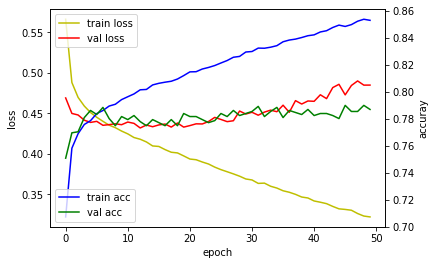

In [13]:
# 학습과정 표시
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(9, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(hist.history)

In [ ]:
X_test[0].shape

In [ ]:
model.evaluate(X_test[:15],y_test[:15])

In [ ]:
model.predict(X_test[:5])

In [ ]:
plt.imshow(X_test[2])
print(y_test[2])

In [ ]:
plt.imshow(X_test[3])
print(y_test[3])